# Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore




# Dataset Loading

In [7]:

# Load the dataset
file_path = "TASK-ML-INTERN.csv"
df = pd.read_csv(file_path)

# Display basic information and first few rows
df.head()


,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [8]:
df.shape

(500, 450)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB


#  Data Exploration and Preprocessing 

In [10]:
# Drop the 'hsi_id' column as it is not needed for numerical processing
df_numeric = df.drop(columns=['hsi_id'])

# Check for missing values
missing_values = df_numeric.isnull().sum().sum()

# Summary statistics of the target variable
target_summary = df_numeric['vomitoxin_ppb'].describe()

missing_values, target_summary

(0,
 count       500.000000
 mean       3410.006000
 std       13095.803483
 min           0.000000
 25%         137.500000
 50%         500.000000
 75%        1700.000000
 max      131000.000000
 Name: vomitoxin_ppb, dtype: float64)

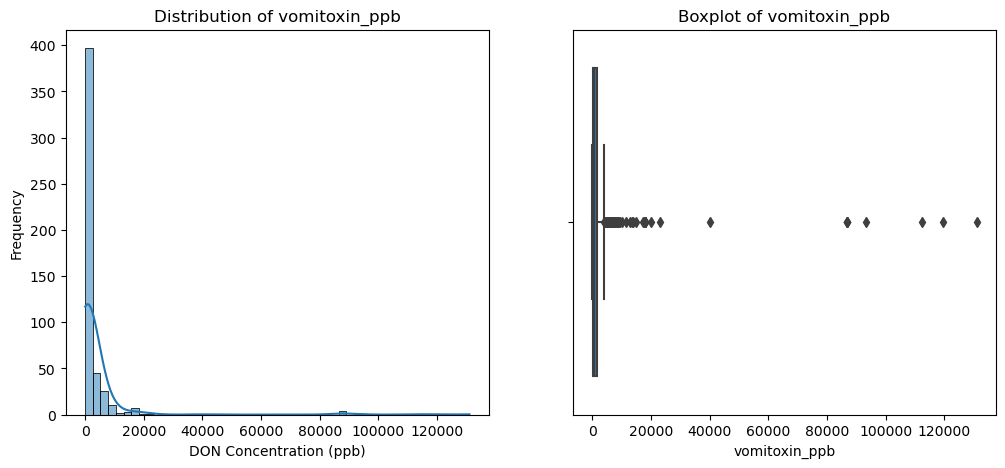

In [11]:
# Set figure size
plt.figure(figsize=(12, 5))

# Histogram of the target variable
plt.subplot(1, 2, 1)
sns.histplot(df['vomitoxin_ppb'], bins=50, kde=True)
plt.title("Distribution of vomitoxin_ppb")
plt.xlabel("DON Concentration (ppb)")
plt.ylabel("Frequency")

# Boxplot of the target variable to visualize outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df['vomitoxin_ppb'])
plt.title("Boxplot of vomitoxin_ppb")

plt.show()

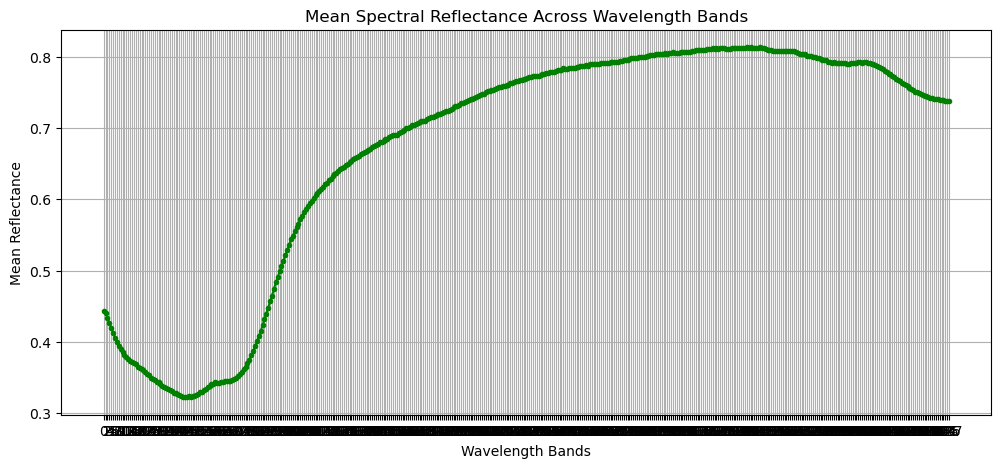

In [12]:
#  mean reflectance across all samples for each band
mean_spectral_reflectance = df.iloc[:, 1:-1].mean()

# mean spectral reflectance across bands
plt.figure(figsize=(12, 5))
plt.plot(mean_spectral_reflectance, color="green", marker=".")
plt.xlabel("Wavelength Bands")
plt.ylabel("Mean Reflectance")
plt.title("Mean Spectral Reflectance Across Wavelength Bands")
plt.grid(True)
plt.show()

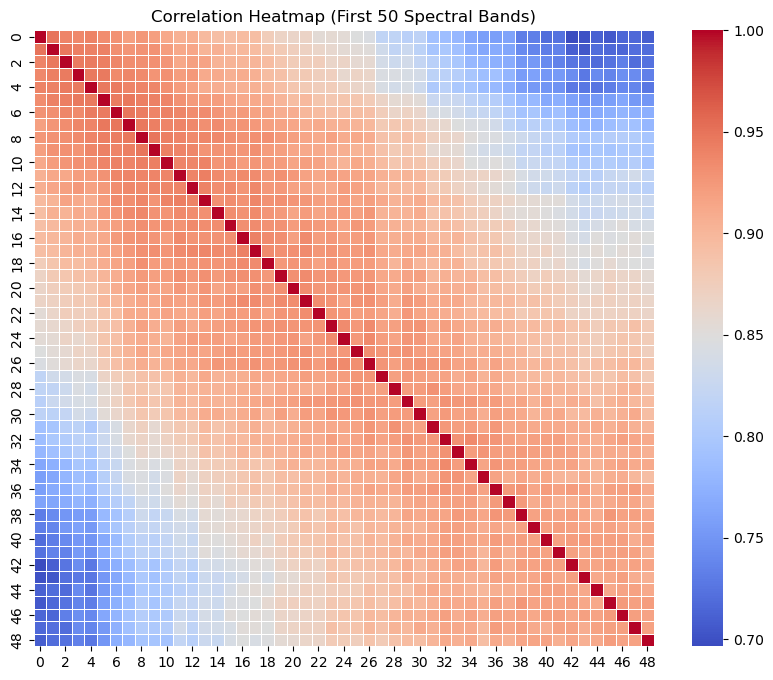

In [13]:
# Correlation heatmap (using a subset to avoid overcrowding)
plt.figure(figsize=(10, 8))
corr_matrix = df.iloc[:, 1:50].corr()  # Taking first 50 bands for visualization
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (First 50 Spectral Bands)")
plt.show()

In [14]:
from scipy.stats import zscore

# Remove outliers in the target variable using Z-score thresholding (Z > 3)
z_scores = np.abs(zscore(df["vomitoxin_ppb"]))
df_clean = df[z_scores < 3]

# Standardize spectral data (excluding the first and last columns)
spectral_data = df_clean.iloc[:, 1:-1]  # Excluding ID and target
spectral_data_scaled = (spectral_data - spectral_data.mean()) / spectral_data.std()

# Update dataset with scaled spectral data
df_clean.iloc[:, 1:-1] = spectral_data_scaled

# Check new dataset shape after outlier removal
df_clean.shape


C:\Users\Naveen Kotyal\AppData\Local\Temp\ipykernel_10112\236039625.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.iloc[:, 1:-1] = spectral_data_scaled


(492, 450)

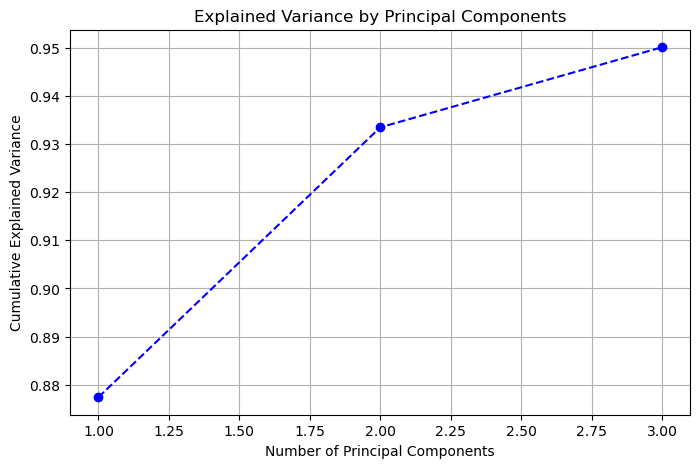

3

In [15]:
from sklearn.decomposition import PCA

# Apply PCA to spectral data (excluding ID and target variable)
pca = PCA(n_components=0.95)  # Retain 95% of variance
pca_transformed = pca.fit_transform(spectral_data_scaled)

# Variance explained by top components
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--", color="b")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.grid(True)
plt.show()

# Number of components selected
num_components = len(explained_variance[explained_variance < 0.95]) + 1
num_components


# Model Building

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare data for modeling
X = pca_transformed  # Reduced features from PCA
y = df_clean["vomitoxin_ppb"].values  # Target variable

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [23]:
y.shape

(492,)

In [17]:
# Define hyperparameter grids for each model
param_grid_rf = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_dt = {
    'max_depth': np.arange(5, 50, 5),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

# Define models
models = {
    "RandomForest": (RandomForestRegressor(random_state=42), param_grid_rf),
    "DecisionTree": (DecisionTreeRegressor(random_state=42), param_grid_dt),
    "XGBoost": (XGBRegressor(objective='reg:squarederror', random_state=42), param_grid_xgb)
}

best_models = {}
results = {}

# Loop through models and apply RandomizedSearchCV
for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,  # Number of random combinations
        scoring='r2',
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    
    best_models[model_name] = search.best_estimator_
    y_pred = search.best_estimator_.predict(X_test)
    
    results[model_name] = {
        "Best Params": search.best_params_,
        "R2 Score": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred)
    }

# Compare models and select the best one
best_model_name = max(results, key=lambda x: results[x]["R2 Score"])
print("\nBest Model:", best_model_name)
print("Best Parameters:", results[best_model_name]["Best Params"])
print("R2 Score:", results[best_model_name]["R2 Score"])
print("Mean Absolute Error:", results[best_model_name]["MAE"])
print("Mean Squared Error:", results[best_model_name]["MSE"])

Training RandomForest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training DecisionTree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Model: RandomForest
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
R2 Score: 0.5796451377362812
Mean Absolute Error: 1176.2747048350582
Mean Squared Error: 3486623.0816696836


Here Random forest performance is good with r2 scoe:0.57 than others

In [24]:
model = RandomForestRegressor(n_estimators=200,min_samples_split=2,min_samples_leaf=4,max_depth=10)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error :",mae)
print("Root Mean Square Error :",rmse)
print("R2 Score :",r2)

Mean Absolute Error : 1214.092981342913
Root Mean Square Error : 1961.033964372704
R2 Score : 0.5363595640679638


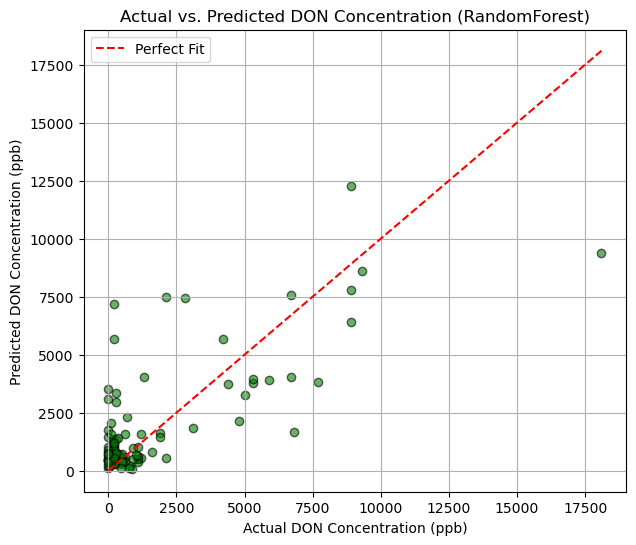

In [20]:
# Scatter plot for Randomforest predictions
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="green", edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red", label="Perfect Fit")
plt.xlabel("Actual DON Concentration (ppb)")
plt.ylabel("Predicted DON Concentration (ppb)")
plt.title("Actual vs. Predicted DON Concentration (RandomForest)")
plt.legend()
plt.grid(True)
plt.show()
